Here we load GBTIDL spectra saved as ASCII's and try to fit the baseline structure using multiple methods. This work was motivated by the difficult baseline structure in the 100m telescope, caused by multipath scattering in the actuator gaps.

This one is just on 108 + 3! (Can we get the CO ascii for this too?)

First we do Ridge Regression (see LSST Hack Day slide--Session 10).

Then we'll try Gaussian Processes (see LSST Session 9) and/or Fourier Filtering.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import ascii
import celerite

%matplotlib inline

In [177]:
# Create functions:

def L2Regression(x, y, nreg=500, lam=1e4):
    # Model for OH emission in outer galaxy 1667:
    vel1 = 15
    vel2 = -25
    vel3 = -65
    vel4 = -80
    vel5 = -120
    sig = 0.8

    # The tophat for the 1667 line:
    tophat1667 = 0.8 * np.ones_like(x)
    tophat1667[x < -150] = 0
    tophat1667[x > 20] = 0

    emission_model = np.exp(-(x - vel1) ** 2 / sig ** 2) \
                + np.exp(-(x - vel2) ** 2 / sig ** 2) \
                + np.exp(-(x - vel3) ** 2 / sig ** 2) \
                + np.exp(-(x - vel4) ** 2 / sig ** 2) \
                + np.exp(-(x - vel5) ** 2 / sig ** 2) \
                + tophat1667 \

    # Compute the weights
    t = (x - x[0]) / (x[-1] - x[0]) - 0.5
    A = np.vander(t, nreg, increasing=True)

    # Compute the weights
    Anew = np.hstack((A, emission_model.reshape(-1, 1)))
    
    # L2-regularized fit
    C = Anew.T.dot(Anew)
    C[np.diag_indices_from(C)] += np.append(1.0 / lam * np.ones(nreg), 0.0)
    wnew = np.linalg.solve(C, Anew.T.dot(y))
    
    # Separate into systematics and emission weights
    w = wnew[:-1]
    depth = wnew[-1]

    # The depth uncertainty
    depth_err = np.sqrt(np.diag(np.linalg.inv(C))[-1])
    
    # The systematics model
    model = A.dot(w)
    
    return model, depth, depth_err

def getHI(l, b):
    if b < 0:
        HIdata = ascii.read('OHData/SuperNova/HIdata/HI'+ str(l) + str(b) + '.txt', data_start=13, data_end=633, names=['VEL (km/s)', 'Ta (K)'])
    else:
        HIdata = ascii.read('OHData/SuperNova/HIdata/HI'+ str(l) +'-' + str(b) + '.txt', data_start=13, data_end=633, names=['VEL (km/s)', 'Ta (K)'])

    HIfreq = HIdata['VEL (km/s)']
    HITa = HIdata['Ta (K)']
    
    return HIfreq, HITa
    
def getOH(l, b, line):
    if b == 0:
        posneg = 'n'
    else: 
        posneg = 'n'
    
    if b == -1:
        b = '1'
    if b == -2:
        b = '2'
        
    if line == '67':
        OHdata = ascii.read('OHData/SuperNova/OHdata/'+ str(l) + '000' + posneg + str(b)+'000_67i.ascii', data_start=3, names=['VEL (km/s)', 'Ta (K)'])
    if line == '65':
        OHdata = ascii.read('OHData/SuperNova/OHdata/'+ str(l) + '000' + posneg + str(b)+'000_65i.ascii', data_start=3, names=['VEL (km/s)', 'Ta (K)'])
    if line == '20':
        OHdata = ascii.read('OHData/SuperNova/OHdata/'+ str(l) + '000' + posneg + str(b)+'000_20i.ascii', data_start=3, names=['VEL (km/s)', 'Ta (K)'])
    
    vel = OHdata['VEL (km/s)']
    Ta = OHdata['Ta (K)']
    igood = np.where((vel >= -750) & (vel <= 1000))
    
    return vel[igood], Ta[igood]

def getCO(l, b):
    COdata = ascii.read('OHData/SuperNova/COdata/CO_'+ str(l)  + str(b) + '.csv', names=['VEL (km/s)', 'Ta (K)'])

    COfreq = COdata['VEL (km/s)']
    COTa = COdata['Ta (K)']
    return COfreq, COTa

In [6]:
# Load the Fits file:

OHdata = ascii.read('OHData/SuperNova/OHdata/108000n2000_67i.ascii', data_start=3, names=['VEL (km/s)', 'Ta (K)'])

In [11]:
# Chop off the sides of the bandpass:
vel = OHdata['VEL (km/s)']
Ta = OHdata['Ta (K)']

igood = np.where((vel >= -750) & (vel <= 1000))

x = vel[igood]
y = Ta[igood]

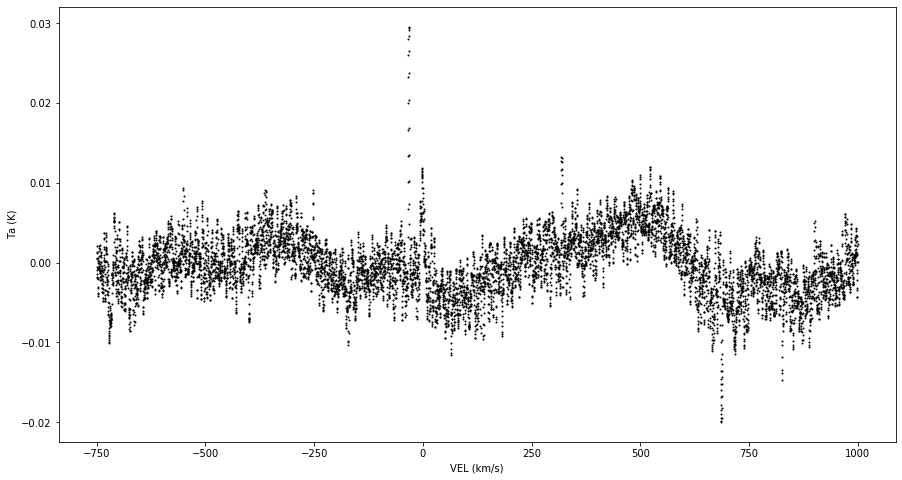

In [12]:
# Plot the data:
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(vel[igood], Ta[igood], 'k.', alpha=1, ms=2)
ax.set_ylabel("Ta (K)")
ax.set_xlabel("VEL (km/s)");

In [116]:
model, i, o = L2Regression(x, y, nreg=1000, lam=1e34)

Text(0.5, 1.0, 'OH 1665 Spectrum Towards Outer Galaxy: Polynomial order: 1000')

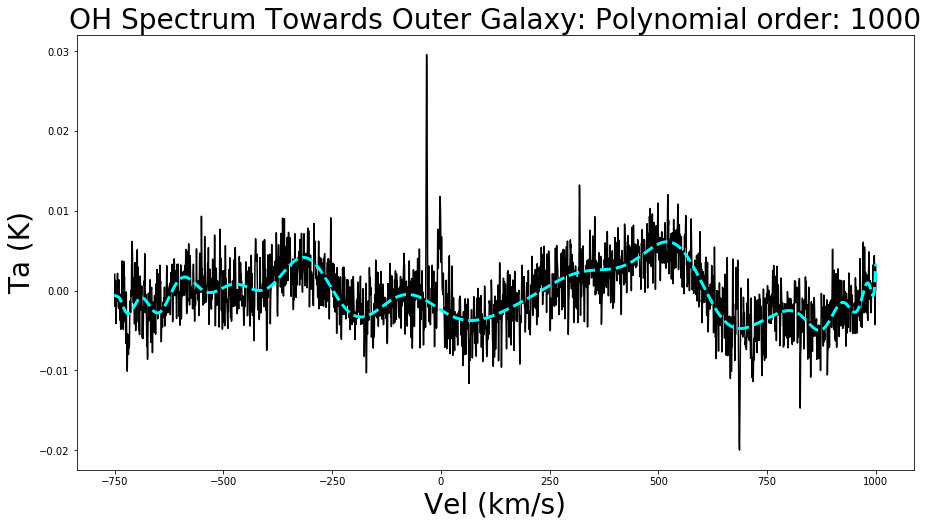

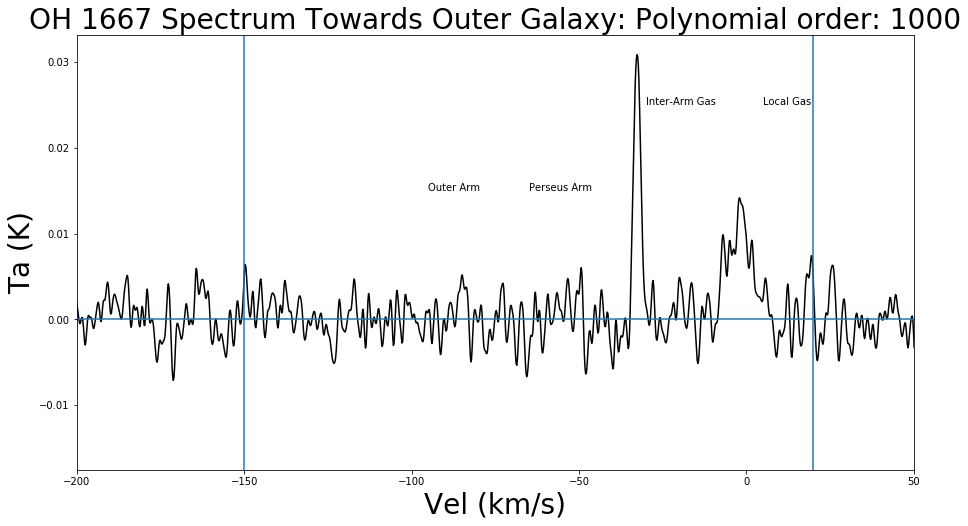

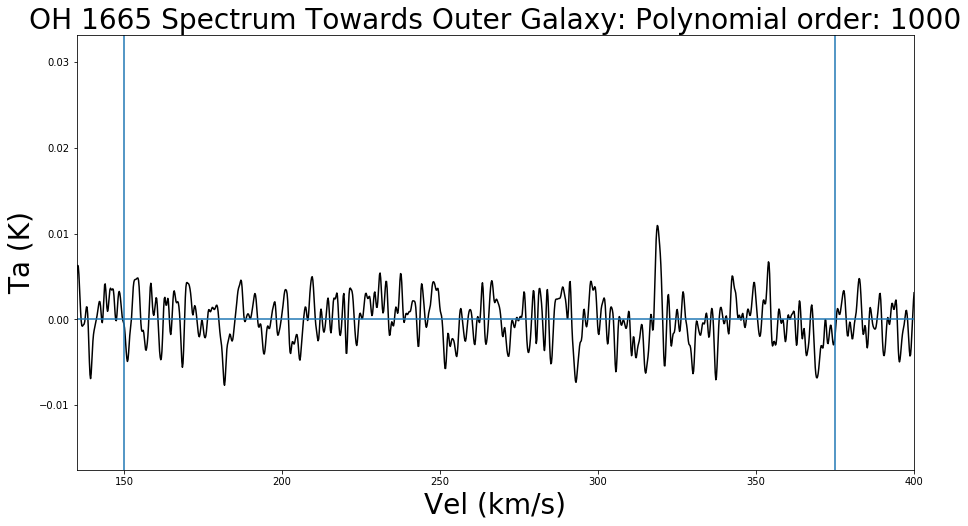

In [117]:
# Plot the fit and the residuals:
nreg=1000

# Plot it!
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y, 'k')
ax.plot(x, model, color='cyan', lw=3, linestyle='--')
ax.set_xlabel("Vel (km/s)", fontsize=28)
ax.set_ylabel("Ta (K)", fontsize=28)
ax.set_title("OH Spectrum Towards Outer Galaxy: Polynomial order: %d" % nreg, fontsize=28)

fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y - model, 'k')
#ax.plot(x_, model_, color='cyan', lw=3, linestyle='--')
ax.set_xlabel("Vel (km/s)", fontsize=28)
ax.set_ylabel("Ta (K)", fontsize=28)
#ax.set_ylim([-0.1, 0.1])
ax.set_xlim([-200, 50])
ax.annotate('Local Gas', (5, 0.025))
ax.annotate('Inter-Arm Gas', (-30, 0.025))
ax.annotate('Perseus Arm', (-65, 0.015))
ax.annotate('Outer Arm', (-95, 0.015))
ax.axhline(0)
ax.axvline(-150)
ax.axvline(20)
ax.set_title("OH 1667 Spectrum Towards Outer Galaxy: Polynomial order: %d" % nreg, fontsize=28)

fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y - model, 'k')
#ax.plot(x_, model_, color='cyan', lw=3, linestyle='--')
ax.set_xlabel("Vel (km/s)", fontsize=28)
ax.set_ylabel("Ta (K)", fontsize=28)
#ax.set_ylim([-0.1, 0.1])
ax.set_xlim([135, 400])
ax.axhline(0)
ax.axvline(150)
ax.axvline(375)
ax.set_title("OH 1665 Spectrum Towards Outer Galaxy: Polynomial order: %d" % nreg, fontsize=28)

In [16]:
# Create two subplots, one for the HI and one for the CO:

In [206]:
# Set Coordinates:

l = 108
b = -2

# Get the HI and CO spectrum:
HIfreq, HITa = getHI(l, b)
COfreq, COTa = getCO(l, b)

# Grab the 1667 spectrum and subtract a baseline:
x67, y67 = getOH(l, b, line='67')
model_67, _, _ = L2Regression(x67, y67, nreg=1000, lam=1e16)

# Grab the 1665 spectrum and subtract a baseline:
x65, y65 = getOH(l, b, line='65')
model_65, _, _ = L2Regression(x65, y65, nreg=1000, lam=1e16)

# Grab the 1720 spectrum and subtract a baseline:
x20, y20 = getOH(l, b, line='20')
model_20, _, _ = L2Regression(x20, y20, nreg=1000, lam=1e16)

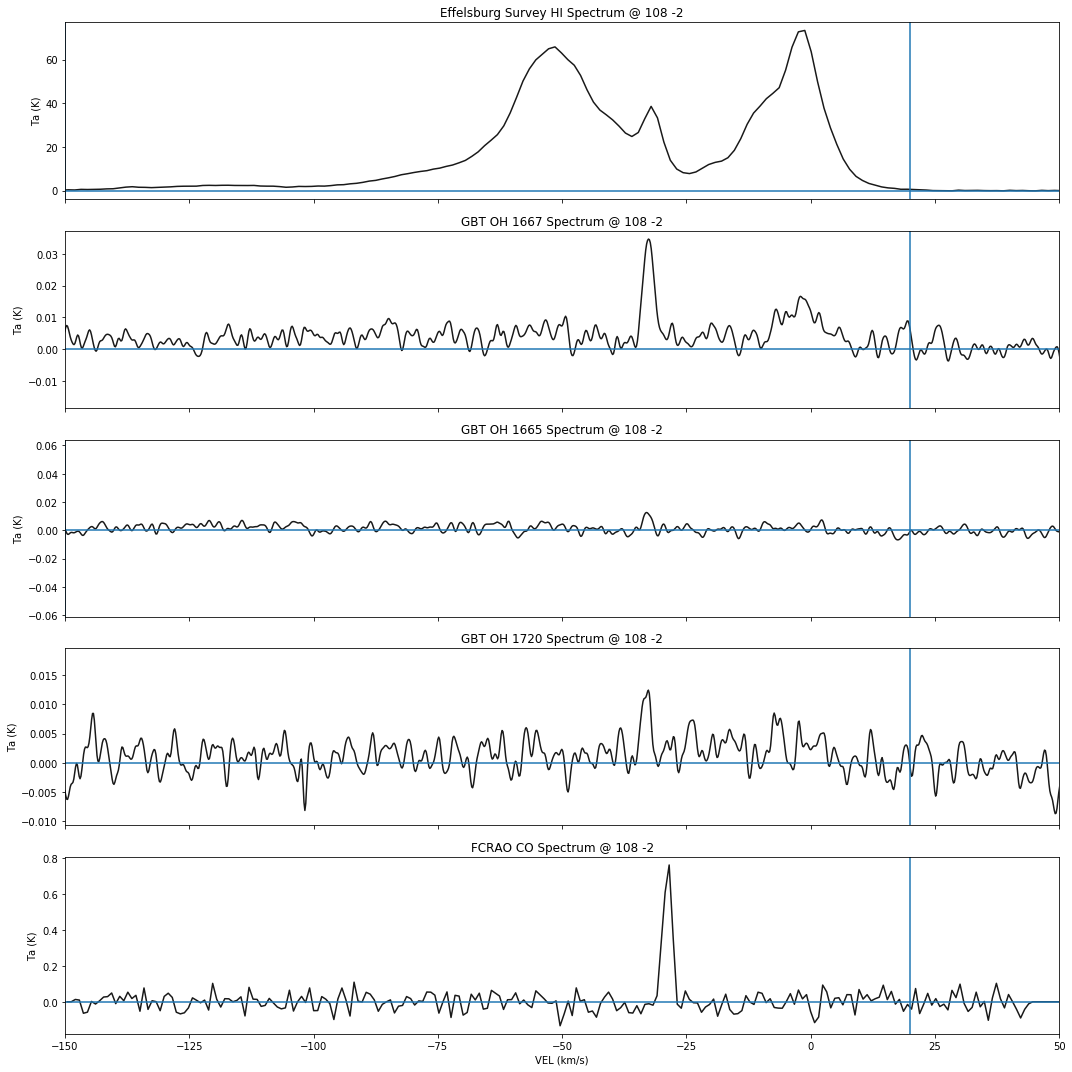

In [207]:
# Plot the data:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(15, 15), sharex='all')

# Plot the HI:
ax1.plot(HIfreq, HITa, 'k', alpha=0.9, ms=2)
ax1.axhline(0)
ax1.axvline(-150)
ax1.axvline(20)
ax1.set_xlim([-200, 50])
ax1.set_title('Effelsburg Survey HI Spectrum @ ' + str(l) +' ' + str(b))
ax1.set_ylabel("Ta (K)")
#ax1.set_xlabel("VEL (km/s)");

# Plot the OH:
ax2.plot(x67, y67-model_67, 'k', alpha=0.9, ms=2)
ax2.axhline(0)
ax2.axvline(20)
ax2.set_xlim([-150, 50])
ax2.set_title('GBT OH 1667 Spectrum @ ' + str(l) +' ' + str(b))
ax2.set_ylabel("Ta (K)")
#ax2.set_xlabel("VEL (km/s)");

# Plot the OH:
ax3.plot(x65, y65-model_65, 'k', alpha=0.9, ms=2)
ax3.axhline(0)
ax3.axvline(-150)
ax3.axvline(20)
ax3.set_xlim([-150, 50])
ax3.set_title('GBT OH 1665 Spectrum @ ' + str(l) +' ' + str(b))
ax3.set_ylabel("Ta (K)")
#ax3.set_xlabel("VEL (km/s)");

# Plot the OH:
ax4.plot(x20, y20-model_20, 'k', alpha=0.9, ms=2)
ax4.axhline(0)
ax4.axvline(20)
ax4.set_xlim([-150, 50])
ax4.set_title('GBT OH 1720 Spectrum @ ' + str(l) +' ' + str(b))
ax4.set_ylabel("Ta (K)")
#ax4.set_xlabel("VEL (km/s)");

# Plot the 20m Data:
ax5.plot(COfreq, COTa, 'k', alpha=0.9, ms=2)
ax5.axhline(0)
ax5.axvline(20)
ax5.set_xlim([-150, 50])
#ax5.set_ylim([-0.1, 8])
ax5.set_title('FCRAO CO Spectrum @ ' + str(l) +' ' + str(b))
ax5.set_ylabel("Ta (K)")
ax5.set_xlabel("VEL (km/s)");

# Plot the CO:
fig.tight_layout()

In [208]:
fig.savefig('108000n200.png', overwrite=True)